In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [30]:
import os
import errno
from multiprocessing.pool import Pool
from tqdm import tqdm
import requests
import pandas as pd
from PIL import Image

def download(pid, image_list, base_url, save_dir, image_size=(224, 224)):
    colors = ['red', 'green', 'blue', 'yellow']
    for i in tqdm(image_list, postfix=pid):
        img_id = i.split('_', 1)
        for color in colors:
            img_path = img_id[0] + '/' + img_id[1] + '_' + color + '.jpg'
            img_name = i + '_' + color + '.png'
            img_url = base_url + img_path

            # Get the raw response from the url
            r = requests.get(img_url, allow_redirects=True, stream=True)
            r.raw.decode_content = True

            # Use PIL to resize the image and to convert it to L
            # (8-bit pixels, black and white)
            im = Image.open(r.raw)
            im = im.resize(image_size, Image.LANCZOS).convert('L')
            im.save(os.path.join(save_dir, img_name), 'PNG')

if __name__ == '__main__':
    # Parameters
    process_num = 224
    image_size = (224, 224)
    url = 'http://v18.proteinatlas.org/images/'
    csv_path =  "HPA/HPAv18RBGY_wodpl.csv"
    save_dir = "data/EXTERNAL"

    # Create the directory to save the images in case it doesn't exist
    try:
        os.makedirs(save_dir)
    except OSError as exc:
        if exc.errno != errno.EEXIST:
            raise
        pass

    print('Parent process %s.' % os.getpid())
    img_list = pd.read_csv(csv_path)['Id']
    list_len = len(img_list)
    p = Pool(process_num)
    for i in range(process_num):
        start = int(i * list_len / process_num)
        end = int((i + 1) * list_len / process_num)
        process_images = img_list[start:end]
        p.apply_async(
            download, args=(str(i), process_images, url, save_dir, image_size)
        )
    print('Waiting for all subprocesses done...')
    p.close()
    p.join()
    print('All subprocesses done.')

Parent process 3089.


  0%|          | 0/333 [00:00<?, ?it/s, 66]

Waiting for all subprocesses done...


  0%|          | 1/334 [00:17<1:13:02, 13.16s/it, 175]

 12%|█▏        | 39/333 [03:03<07:38,  1.56s/it, 170] 

All subprocesses done.


In [2]:
import os
from pathlib import Path
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from fastai import *
from fastai.vision import *

from utils import open_4_channel
from resnet import Resnet4Channel

In [3]:
bs = 64

In [4]:
path = Path('data')

In [ ]:
name_label_dict = {
    0:   ('Nucleoplasm', 12885),
    1:   ('Nuclear membrane', 1254),
    2:   ('Nucleoli', 3621),
    3:   ('Nucleoli fibrillar center', 1561),
    4:   ('Nuclear speckles', 1858),
    5:   ('Nuclear bodies', 2513),
    6:   ('Endoplasmic reticulum', 1008),   
    7:   ('Golgi apparatus', 2822),
    8:   ('Peroxisomes', 53), 
    9:   ('Endosomes', 45),
    10:  ('Lysosomes', 28),
    11:  ('Intermediate filaments', 1093), 
    12:  ('Actin filaments', 688),
    13:  ('Focal adhesion sites', 537),  
    14:  ('Microtubules', 1066), 
    15:  ('Microtubule ends', 21),
    16:  ('Cytokinetic bridge', 530),
    17:  ('Mitotic spindle', 210),
    18:  ('Microtubule organizing center', 902),
    19:  ('Centrosome', 1482),
    20:  ('Lipid droplets', 172),
    21:  ('Plasma membrane', 3777),
    22:  ('Cell junctions', 802),
    23:  ('Mitochondria', 2965),
    24:  ('Aggresome', 322),
    25:  ('Cytosol', 8228),
    26:  ('Cytoplasmic bodies', 328),   
    27:  ('Rods &amp; rings', 11)
    }

# n_labels = 50782

def cls_wts(label_dict, mu=0.5):
    prob_dict, prob_dict_bal = {}, {}
    max_ent_wt = 1/28
    for i in range(28):
        prob_dict[i] = label_dict[i][1]/n_labels
        if prob_dict[i] > max_ent_wt:
            prob_dict_bal[i] = prob_dict[i]-mu*(prob_dict[i] - max_ent_wt)
        else:
            prob_dict_bal[i] = prob_dict[i]+mu*(max_ent_wt - prob_dict[i])            
    return prob_dict, prob_dict_bal

In [12]:
label_names = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

In [33]:
DIR = 'data/EXTERNAL'
print(len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))

7716


In [47]:
train_labels = pd.read_csv("HPA/HPAv18RBGY_wodpl.csv")
train_labels = train_labels[:7774]
len(train_labels)

7774

In [46]:
train_labels.head()

,Id,Target
0,10580_1610_C1_1,13 25 0 2 21
1,10580_1610_C1_2,13 25 0 2 21
2,10580_1756_B1_1,13 25 0 2 21
3,10580_1756_B1_2,13 25 0 2 21
4,10580_1758_B1_1,13 25 0 2 21


In [38]:
df = train_labels.copy()

In [39]:
# df = pd.read_csv(path/'external_lables.csv')
# del df['names']

df.head()

,Id,Target
0,10580_1610_C1_1,13 25 0 2 21
1,10580_1610_C1_2,13 25 0 2 21
2,10580_1756_B1_1,13 25 0 2 21
3,10580_1756_B1_2,13 25 0 2 21
4,10580_1758_B1_1,13 25 0 2 21


In [55]:
path= "."
#src split the training set into training set ~ 80% and testing set ~ 20% /parameters changed
src = (ImageItemList.from_csv(path,"HPA/HPAv18RBGY_wodpl.csv", folder='data/EXTERNAL', suffix='.png')
       .random_split_by_pct(0.1)
       .label_from_df(sep=' ',  classes=[str(i) for i in range(28)]))

print(src)

FileNotFoundError: [Errno 2] No such file or directory: './data/EXTERNAL/10580_1610_C1_1.png'

In [10]:
count_labels = Counter(list(chain.from_iterable(df['labels'].values)))


NameError: name 'chain' is not defined

In [62]:
'data/EXTERNAL/*'[3]

'a'

(224, 224)


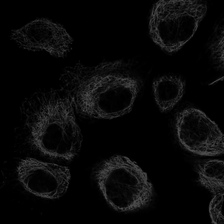

In [57]:
from PIL import Image
from glob import glob

img = Image.open(glob('data/EXTERNAL/*')[0])
print(img.size)
img

In [ ]:
src.train.x.create_func = open_4_channel
src.train.x.open = open_4_channel

In [ ]:
src.valid.x.create_func = open_4_channel
src.valid.x.open = open_4_channel

In [ ]:
test_ids = list(sorted({fname.split('_')[0] for fname in os.listdir(path/'test')}))

In [ ]:
test_fnames = [path/'test'/test_id for test_id in test_ids]

In [ ]:
test_fnames[:5]

In [ ]:
#add test set to src
src.add_test(test_fnames, label='0');

In [ ]:
src.test.x.create_func = open_4_channel
src.test.x.open = open_4_channel

In [ ]:
#means, variance for each channel of dataset
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

In [ ]:
#transformations
#no orientation in images
trn_tfms,_ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1,
                      max_lighting=0.05, max_warp=0.)

In [ ]:
# out of memory error with size 512
#data with transformation
data = (src.transform((trn_tfms, _), size=224) 
        .databunch().normalize(protein_stats))

In [ ]:
#Some images
data.show_batch(rows=3, figsize=(12,9))

In [ ]:
def resnet50(pretrained):
    return Resnet4Channel(encoder_depth=50)

In [ ]:
# copied from https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py
def _resnet_split(m): return (m[0][6],m[1])

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()
    
    
def acc(preds,targs,th=0.0):
    preds = (preds > th).int()
    targs = targs.int()
    return (preds==targs).float().mean()


In [ ]:
f1_score = partial(fbeta, thresh=0.2, beta=1)

In [ ]:
learn = create_cnn(
    data,
    resnet50,
    cut=-2,
    split_on=_resnet_split,
    loss_func=F.binary_cross_entropy_with_logits,
    path=path,    
    metrics=[f1_score],
    ps= 0.3 # added dropout 50%
)

In [ ]:
#learn.opt_fn = optim.Adam
#learn.clip = 1.0 #gradient clipping
#learn.crit = FocalLoss()
#learn.precompute = True

In [ ]:
learn.load('filtered_model_weights')

In [ ]:
learn.save('filtered_model_weights')

In [ ]:
learn.load('temp')

In [ ]:
learn.precompute=True
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
lr = 1e-2
learn.fit_one_cycle(3, lr)

In [ ]:
learn.precompute = False

In [ ]:
learn.fit_one_cycle(3, lr)

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(2, slice(lr/9,lr/3,lr))

In [ ]:
__all__ = ['GeneralScheduler', 'TrainingPhase']

@dataclass
class TrainingPhase():
    "Schedule `lrs` and `moms` according to `lr_anneal` and `mom_anneal` across a `length` schedule."
    length:int
    lrs:Floats
    moms:Floats
    lr_anneal:AnnealFunc=None
    mom_anneal:AnnealFunc=None

    def __post_init__(self)->None:
        self.lr_step = Stepper(self.lrs, self.length, self.lr_anneal)
        self.mom_step = Stepper(self.moms, self.length, self.mom_anneal)

@dataclass
class GeneralScheduler(Callback):
    "Schedule multiple `TrainingPhase` for a `Learner`."
    learn:Learner
    phases:Collection[TrainingPhase]

    def on_train_begin(self, n_epochs:int, **kwargs:Any)->None:
        "Initialize the lr and mom schedules for training."
        self.lr_scheds = [p.lr_step for p in self.phases]
        self.mom_scheds = [p.mom_step for p in self.phases]
        self.opt = self.learn.opt
        self.opt.lr,self.opt.mom = self.lr_scheds[0].start,self.mom_scheds[0].start
        self.idx_s = 0

    def on_batch_end(self, train, **kwargs:Any)->None:
        "Take a step in lr,mom sched, start next stepper when the current one is complete."
        if train:
            if self.idx_s >= len(self.lr_scheds): return True
            self.opt.lr = self.lr_scheds[self.idx_s].step()
            self.opt.mom = self.mom_scheds[self.idx_s].step()
            if self.lr_scheds[self.idx_s].is_done:
                self.idx_s += 1

In [ ]:
def fit_sgd_warm(learn, n_cycles, lr, mom, cycle_len, cycle_mult):
    n = len(learn.data.train_dl)
    phases = [TrainingPhase(n * (cycle_len * cycle_mult**i), lr, mom, lr_anneal=annealing_cos) for i in range(n_cycles)]
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    if cycle_mult != 1:
        total_epochs = int(cycle_len * (1 - (cycle_mult)**n_cycles)/(1-cycle_mult)) 
    else: total_epochs = n_cycles * cycle_len
    learn.fit(total_epochs)

In [ ]:
#parameters : learn, n_cycles, lr, mom, cycle_len, cycle_mult
fit_sgd_warm(learn, 5, 1e-3, 0.9, 1, 2)

In [ ]:
learn.recorder.plot_lr()

In [ ]:
learn.save("last1")

In [ ]:
learn.load('last')

### TTA

In [ ]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

preds_t,y_t = learn.TTA()
preds_t = np.stack(preds_t, axis=-1)
preds_t = sigmoid_np(preds_t)
pred_t = preds_t.max(axis=-1) #max works better for F1 macro score

In [ ]:
SAMPLE = path/'sample_submission.csv'
def save_pred(pred, th=0.5, fname='protein_classification.csv'):
    pred_list = []
    for line in pred:
        s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
        pred_list.append(s)
        
    sample_df = pd.read_csv(SAMPLE)
    sample_list = list(sample_df.Id)
    pred_dic = dict((key, value) for (key, value) 
                in zip(preds,pred_list))
    pred_list_cor = [pred_dic[Id] for Id in sample_list]
    df = pd.DataFrame({'Id':sample_list,'Predicted':pred_list_cor})
    df.to_csv(fname, header=True, index=False)
    
    
th_t = np.array([0.565,0.39,0.55,0.345,0.33,0.39,0.33,0.45,0.38,0.39,
               0.34,0.42,0.31,0.38,0.49,0.50,0.38,0.43,0.46,0.40,
               0.39,0.505,0.37,0.47,0.41,0.545,0.32,0.1])
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(preds_t,th_t)

In [ ]:
th_t = np.array([0.565,0.39,0.55,0.345,0.33,0.39,0.33,0.45,0.38,0.39,
               0.34,0.42,0.31,0.38,0.49,0.50,0.38,0.43,0.46,0.40,
               0.39,0.505,0.37,0.47,0.41,0.545,0.32,0.1])
print('Fractions: ',(pred_t > th_t).mean(axis=0))
# save_pred(pred_t,th_t)
save_pred(pred_t,th_t)


### Submission

In [ ]:
preds,_ = learn.get_preds(DatasetType.Test)

In [ ]:
pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>0.2)[0]])) for row in np.array(preds)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv('protein_predictions_datablocks.csv', header=True, index=False)

In [ ]:
!kaggle competitions submit human-protein-atlas-image-classification -f protein_predictions_datablocks.csv -m "sumbission"